# Host-Phage Biomass Optima

In this notebook, we examine the tradeoffs between the host and phage biomass production.

We are focused on the effects of nutrient uptake and its interplay with AMG expression. Because the gene phoH directly impacts P uptake, its effect is considered separately through an "excess" or "extreme" P uptake rate.

In [1]:
import json
import cobra
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
from cobra.flux_analysis.variability import flux_variability_analysis as fva
from amg_utils import amg_limits

cobra.Configuration.solver = "glpk"


In [2]:
model = cobra.io.read_sbml_model("model_files/ProchlorococcusMED4+PHM2v1.xml")

In [3]:
amgs = json.loads(open("model_files/amg_reactions.json").read())
amg_gene_names = json.loads(open("model_files/amg_gene_map.json").read())
amg_rxn_names = {k: f"{v}: {k}" for k, v in amg_gene_names.items()}
scenarios = [
    "Unconstrained Uptake",
    "Increased P uptake",
    "Phage-Optimal P uptake",
    "Extreme P uptake",
    "Mild N limit",
    "Mild P limit",
    "Moderate N limit",
    "Moderate P limit",
    "Severe N limit",
    "Severe P limit",
]

scenario_colors = {
    "Unconstrained Uptake": "black",
    "Increased P uptake": "#ffbbff",
    "Phage-Optimal P uptake": "#ff77ff",
    "Extreme P uptake": "#ff00ff",
    "Mild N limit": "#8888ff",
    "Mild P limit": "#66dd66",
    "Moderate N limit": "#4444cc",
    "Moderate P limit": "#33aa33",
    "Severe N limit": "#222266",
    "Severe P limit": "#116611",
}

## Compute uptake limits

We conduct selective FVA with host biomass optimized, then with phage biomass optimized, so that we can find the ranges of optimal nutrient uptake and define nutrient limitation and excess scenarios.

In [4]:
with model as host_model:
    h_fva = fva(
        host_model,
        [host_model.reactions.AmmoniaEX, host_model.reactions.FAKEOrthophosphateEX],
    )
with model as phage_model:
    phage_model.objective = phage_model.reactions.PHM2_prodrxn_VN.flux_expression
    p_fva = fva(
        phage_model,
        [phage_model.reactions.AmmoniaEX, phage_model.reactions.FAKEOrthophosphateEX],
    )

print("Host-optimal")
print(h_fva)
print()
print("Phage-optimal")
print(p_fva)

Host-optimal
                       minimum   maximum
AmmoniaEX            -0.864117 -0.855149
FAKEOrthophosphateEX -0.033099 -0.033099

Phage-optimal
                       minimum   maximum
AmmoniaEX            -1.607938 -1.607938
FAKEOrthophosphateEX -0.183978 -0.183978


In [5]:
N_LIMIT_VALS = [-0.86 * 1.5, -0.86 * 0.9, -0.86 * 0.2]
P_LIMIT_VALS = [-0.033 * 1.5, -0.033 * 0.9, -0.033 * 0.2]

In [6]:
def set_nutrient_limits(model, scenario):
    if scenario == "Mild N limit":
        model.reactions.AmmoniaEX.bounds = N_LIMIT_VALS[0], 0
    elif scenario == "Mild P limit":
        model.reactions.FAKEOrthophosphateEX.bounds = (
            P_LIMIT_VALS[0],
            0,
        )
    elif scenario == "Moderate N limit":
        model.reactions.AmmoniaEX.bounds = N_LIMIT_VALS[1], 0
    elif scenario == "Moderate P limit":
        model.reactions.FAKEOrthophosphateEX.bounds = (
            P_LIMIT_VALS[1],
            0,
        )
    elif scenario == "Severe N limit":
        model.reactions.AmmoniaEX.bounds = N_LIMIT_VALS[2], 0
    elif scenario == "Severe P limit":
        model.reactions.FAKEOrthophosphateEX.bounds = (
            P_LIMIT_VALS[2],
            0,
        )
    elif scenario == "Increased P uptake":
        model.reactions.FAKEOrthophosphateEX.bounds = (
            2 * P_LIMIT_VALS[0],  # approx 3x host-optimal
            2 * P_LIMIT_VALS[0],
        )
    elif scenario == "Phage-Optimal P uptake":
        model.reactions.FAKEOrthophosphateEX.bounds = (
            4 * P_LIMIT_VALS[0],  # approx 6x host-optimal
            4 * P_LIMIT_VALS[0],
        )
    elif scenario == "Extreme P uptake":
        model.reactions.FAKEOrthophosphateEX.bounds = (
            8 * P_LIMIT_VALS[0],  # approx 12x host-optimal
            8 * P_LIMIT_VALS[0],
        )


def set_amg_limits(model, amg, direction, tol=0.1, optimum_fraction=1):
    model.reactions.get_by_id(amg).bounds = amg_limits(
        model, amg, direction, tol, optimum_fraction
    )

In [7]:
host_optimum_frac = np.linspace(0, 1, 33)

## Compute trade-off without AMGs

Here, we fix the host biomass to some fraction of its optimal value in each nutrient scenario (and vary this fraction). For each fixed host biomass rate, we compute the optimal phage biomass rate. The resulting curve is then plotted for each nutrient scenario.

In [8]:
scenario_outputs = {}
for scenario in tqdm(scenarios):
    host_biomass = []
    phage_biomass_min = []
    phage_biomass_max = []
    for frac in host_optimum_frac:
        with model as host_model:
            set_nutrient_limits(host_model, scenario)
            host_optimum = host_model.slim_optimize()
            host_bio = host_optimum * frac
            host_biomass.append(host_bio)
            host_model.reactions.BIOMASS.bounds = host_bio, host_bio
            host_model.objective = host_model.reactions.PHM2_prodrxn_VN.flux_expression
            phage_biomass_max.append(host_model.slim_optimize())

            host_model.objective = -host_model.reactions.PHM2_prodrxn_VN.flux_expression
            phage_biomass_min.append(-host_model.slim_optimize())

    med4_opt = pd.DataFrame(
        np.array([host_biomass, phage_biomass_min, phage_biomass_max]).T,
        columns=["host biomass", "phage biomass min", "phage biomass max"],
        dtype="float",
    )

    scenario_outputs[scenario] = med4_opt.map(lambda x: x if np.abs(x) > 1e-10 else 0)


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


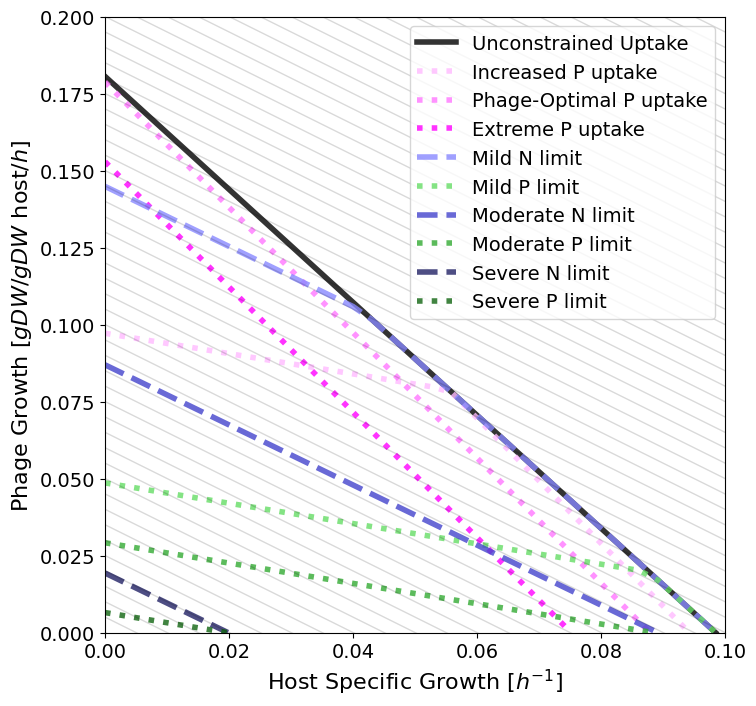

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))
for scenario in scenarios:
    scenario_outputs[scenario].plot(
        x="host biomass",
        y="phage biomass max",
        ax=ax,
        label=scenario,
        color=scenario_colors[scenario],
        linewidth=4,
        alpha=0.8,
        linestyle="dashed"
        if "N" in scenario
        else "dotted"
        if "P" in scenario
        else "solid",
    )
for m in np.linspace(0.0, 0.4, 81):
    ax.plot(host_optimum_frac, m - host_optimum_frac, "k-", linewidth=1, alpha=0.15)
ax.set_xlim(0, 0.1)
ax.set_ylim(0, 0.2)
ax.set_xlabel(r"Host Specific Growth $[h^{-1}]$", fontsize=16)
ax.set_ylabel(r"Phage Growth $[gDW /gDW$ host$ / h]$", fontsize=16)
ax.tick_params(labelsize=14)
ax.legend(fontsize=14)
plt.show()

In [10]:
pref = scenario_outputs["Unconstrained Uptake"]["phage biomass max"].max()
href = scenario_outputs["Unconstrained Uptake"]["host biomass"].max()
print("phage:", pref)
print("host:", href)
print()

for scenario in scenarios:
    print(scenario, "(fractional reduction in biomass rate)")
    print("phage:", 1 - scenario_outputs[scenario]["phage biomass max"].max() / pref)
    print("host:", 1 - scenario_outputs[scenario]["host biomass"].max() / href)
    print()


phage: 0.18055459015899056
host: 0.09846248800237331

Unconstrained Uptake (fractional reduction in biomass rate)
phage: 0.0
host: 0.0

Increased P uptake (fractional reduction in biomass rate)
phage: 0.4618935356906373
host: 0.04297206838437029

Phage-Optimal P uptake (fractional reduction in biomass rate)
phage: 0.010140780396550197
host: 0.10752743874319426

Extreme P uptake (fractional reduction in biomass rate)
phage: 0.15334009273081772
host: 0.23663817946079724

Mild N limit (fractional reduction in biomass rate)
phage: 0.1977301657608801
host: 7.327471962526033e-15

Mild P limit (fractional reduction in biomass rate)
phage: 0.730946767846121
host: 8.992806499463768e-15

Moderate N limit (fractional reduction in biomass rate)
phage: 0.5186380994566284
host: 0.09489428310724302

Moderate P limit (fractional reduction in biomass rate)
phage: 0.8385680607114656
host: 0.10270397316120905

Severe N limit (fractional reduction in biomass rate)
phage: 0.8930306887678465
host: 0.7988653

## Compute trade-offs with AMGs

The above process is repeated, but with each AMG-hijacked reaction fixed to its target range (see `amg_utils.set_amg_limits`). We plot the results for 16 AMG-hijacked reactions (the 17th, *phoH* hijacking of phosphate uptake, is incorporated as the high-P nutrient scenarios). We then select three examples to showcase.


 R05223 raw increase 
 ----------
Unconstrained Uptake
Increased P uptake
Phage-Optimal P uptake
Extreme P uptake
Mild N limit
Mild P limit
Moderate N limit
Moderate P limit
Severe N limit
Severe P limit

 R01063 absolute decrease 
 ----------
Unconstrained Uptake
Increased P uptake
Phage-Optimal P uptake
Extreme P uptake
Mild N limit
Mild P limit
Moderate N limit
Moderate P limit
Severe N limit
Severe P limit

 R01523 absolute decrease 
 ----------
Unconstrained Uptake
Increased P uptake
Phage-Optimal P uptake
Extreme P uptake
Mild N limit
Mild P limit
Moderate N limit
Moderate P limit
Severe N limit
Severe P limit

 R05818 raw increase 
 ----------
Unconstrained Uptake
Increased P uptake
Phage-Optimal P uptake
Extreme P uptake
Mild N limit
Mild P limit
Moderate N limit
Moderate P limit
Severe N limit
Severe P limit

 R00311 raw increase 
 ----------
Unconstrained Uptake
Increased P uptake
Phage-Optimal P uptake
Extreme P uptake
Mild N limit
Mild P limit
Moderate N limit
Moderate P l

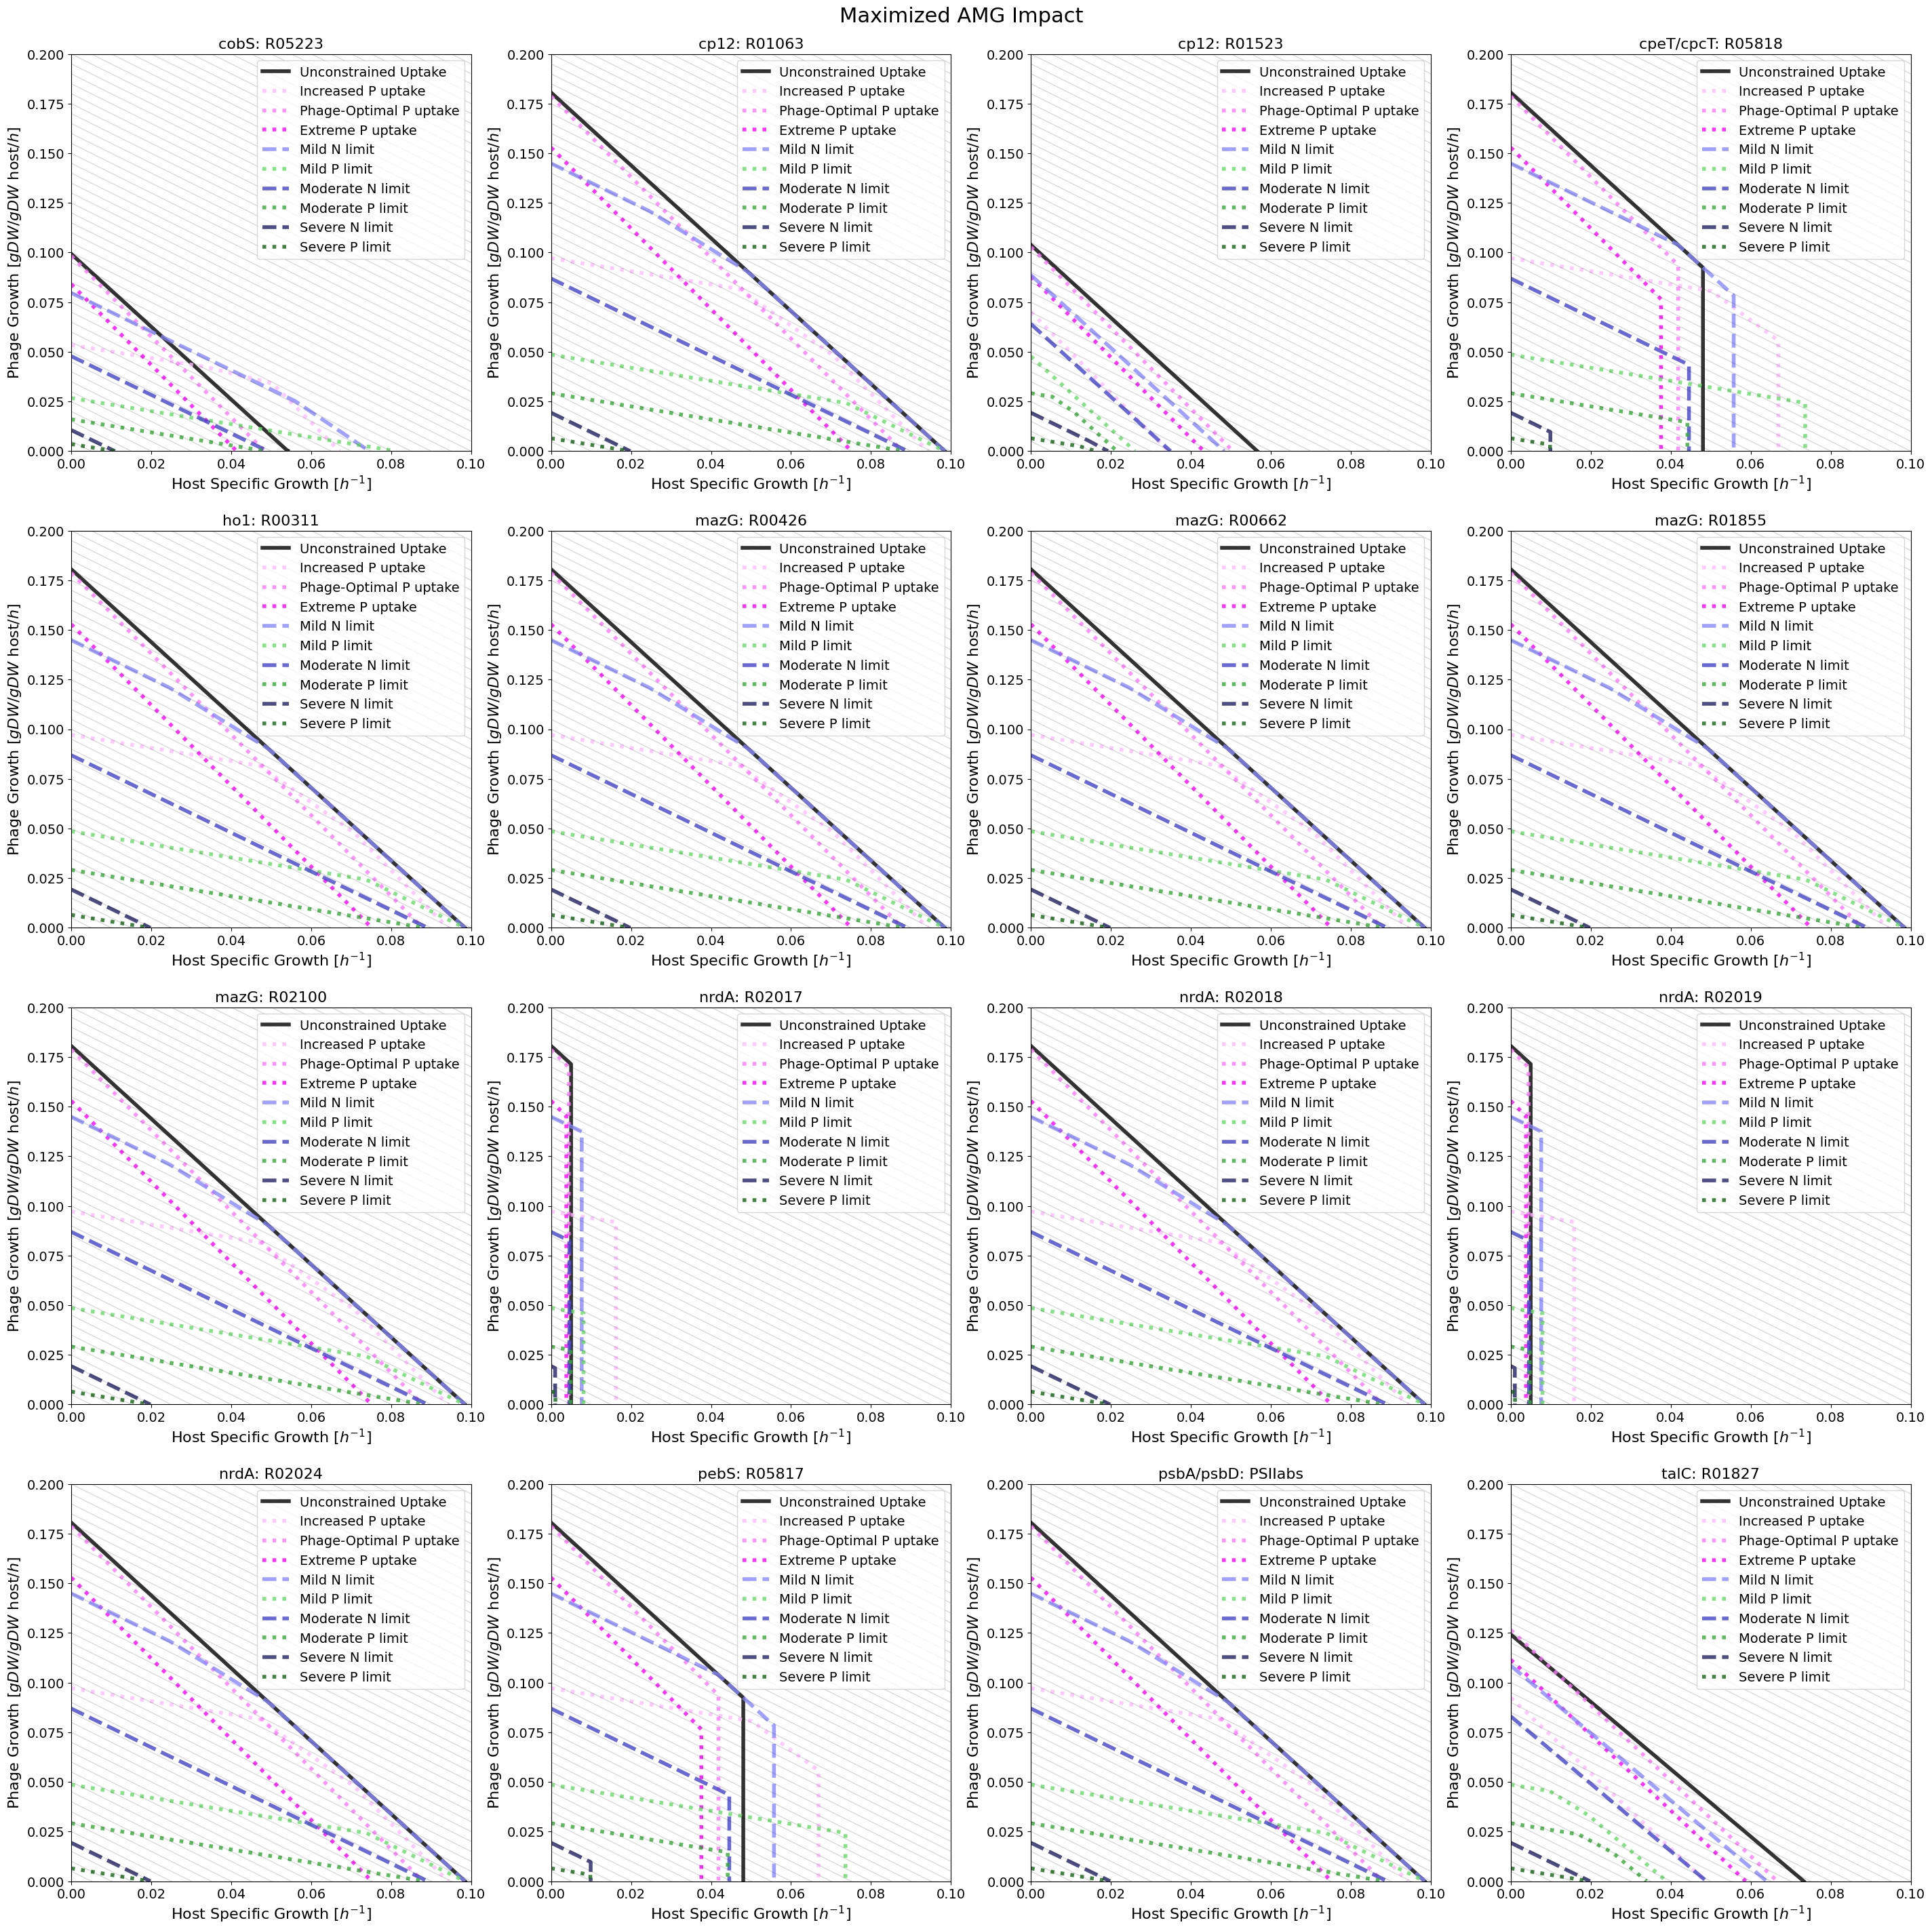

In [11]:
fig, axs = plt.subplots(4, 4, figsize=(35, 35))
amg_noP = {k: v for k, v in amgs.items() if k != "FAKEOrthophosphateEX"}
for (amg, direction), ax in zip(
    sorted(amg_noP.items(), key=lambda x: amg_rxn_names[x[0]]), axs.flatten()
):
    print("\n", amg, direction, "\n", "-" * 10)
    scenario_outputs = {}
    for scenario in scenarios:
        print(scenario)
        host_biomass_frac = []
        phage_biomass_max_frac = []
        phage_biomass_min_frac = []
        # for frac in host_optimum_frac:
        for frac in np.linspace(0, 1, 5):
            with model as host_model:
                set_nutrient_limits(host_model, scenario)
                host_model.objective = (
                    host_model.reactions.PHM2_prodrxn_VN.flux_expression
                )
                set_amg_limits(host_model, amg, direction, optimum_fraction=0.5)
                host_model.objective = host_model.reactions.BIOMASS.flux_expression
                host_optimum = host_model.slim_optimize()
                host_bio = host_optimum * frac
                host_biomass_frac.append(host_bio)

                host_model.reactions.BIOMASS.bounds = host_bio, host_bio

                # Now, with AMG and biomass fixed, compute the optimal phage
                # biomass
                host_model.objective = (
                    host_model.reactions.PHM2_prodrxn_VN.flux_expression
                )
                phage_biomass_max_frac.append(host_model.slim_optimize())
                host_model.objective = (
                    -host_model.reactions.PHM2_prodrxn_VN.flux_expression
                )
                phage_biomass_min_frac.append(host_model.slim_optimize())
        host_biomass_frac.append(host_biomass_frac[-1])
        phage_biomass_min_frac.append(phage_biomass_min_frac[-1])
        phage_biomass_max_frac.append(phage_biomass_min_frac[-1])
        med4_opt = pd.DataFrame(
            np.array(
                [host_biomass_frac, phage_biomass_max_frac, phage_biomass_min_frac]
            ).T,
            columns=["host biomass", "phage biomass max", "phage biomass min"],
            dtype="float",
        )
        scenario_outputs[scenario] = med4_opt.map(
            lambda x: x if np.abs(x) > 1e-10 else 0
        )

    for scenario in scenarios:
        scenario_outputs[scenario].plot(
            x="host biomass",
            y="phage biomass max",
            ax=ax,
            label=scenario,
            color=scenario_colors[scenario],
            linewidth=4,
            alpha=0.8,
            linestyle="dashed"
            if "N" in scenario
            else "dotted"
            if "P" in scenario
            else "solid",
        )
    for m in np.linspace(0.0, 0.4, 81):
        ax.plot(host_optimum_frac, m - host_optimum_frac, "k-", linewidth=1, alpha=0.15)
    ax.set_xlim(0, 0.1)
    ax.set_ylim(0, 0.2)
    ax.set_xlabel(r"Host Specific Growth $[h^{-1}]$", fontsize=16)
    ax.set_ylabel(r"Phage Growth $[gDW /gDW$ host$ / h]$", fontsize=16)
    ax.tick_params(labelsize=14)
    ax.legend(fontsize=14, loc="upper right")
    ax.set_title(f"{amg_rxn_names[amg]}", fontsize=16)
fig.suptitle("Maximized AMG Impact", fontsize=22, y=0.9)
plt.show()


 No AMG  
 ----------
Unconstrained Uptake
Increased P uptake
Phage-Optimal P uptake
Extreme P uptake
Mild N limit
Mild P limit
Moderate N limit
Moderate P limit
Severe N limit
Severe P limit

 R01523 absolute decrease 
 ----------
Unconstrained Uptake
Increased P uptake
Phage-Optimal P uptake
Extreme P uptake
Mild N limit
Mild P limit
Moderate N limit
Moderate P limit
Severe N limit
Severe P limit

 R05817 raw increase 
 ----------
Unconstrained Uptake
Increased P uptake
Phage-Optimal P uptake
Extreme P uptake
Mild N limit
Mild P limit
Moderate N limit
Moderate P limit
Severe N limit
Severe P limit


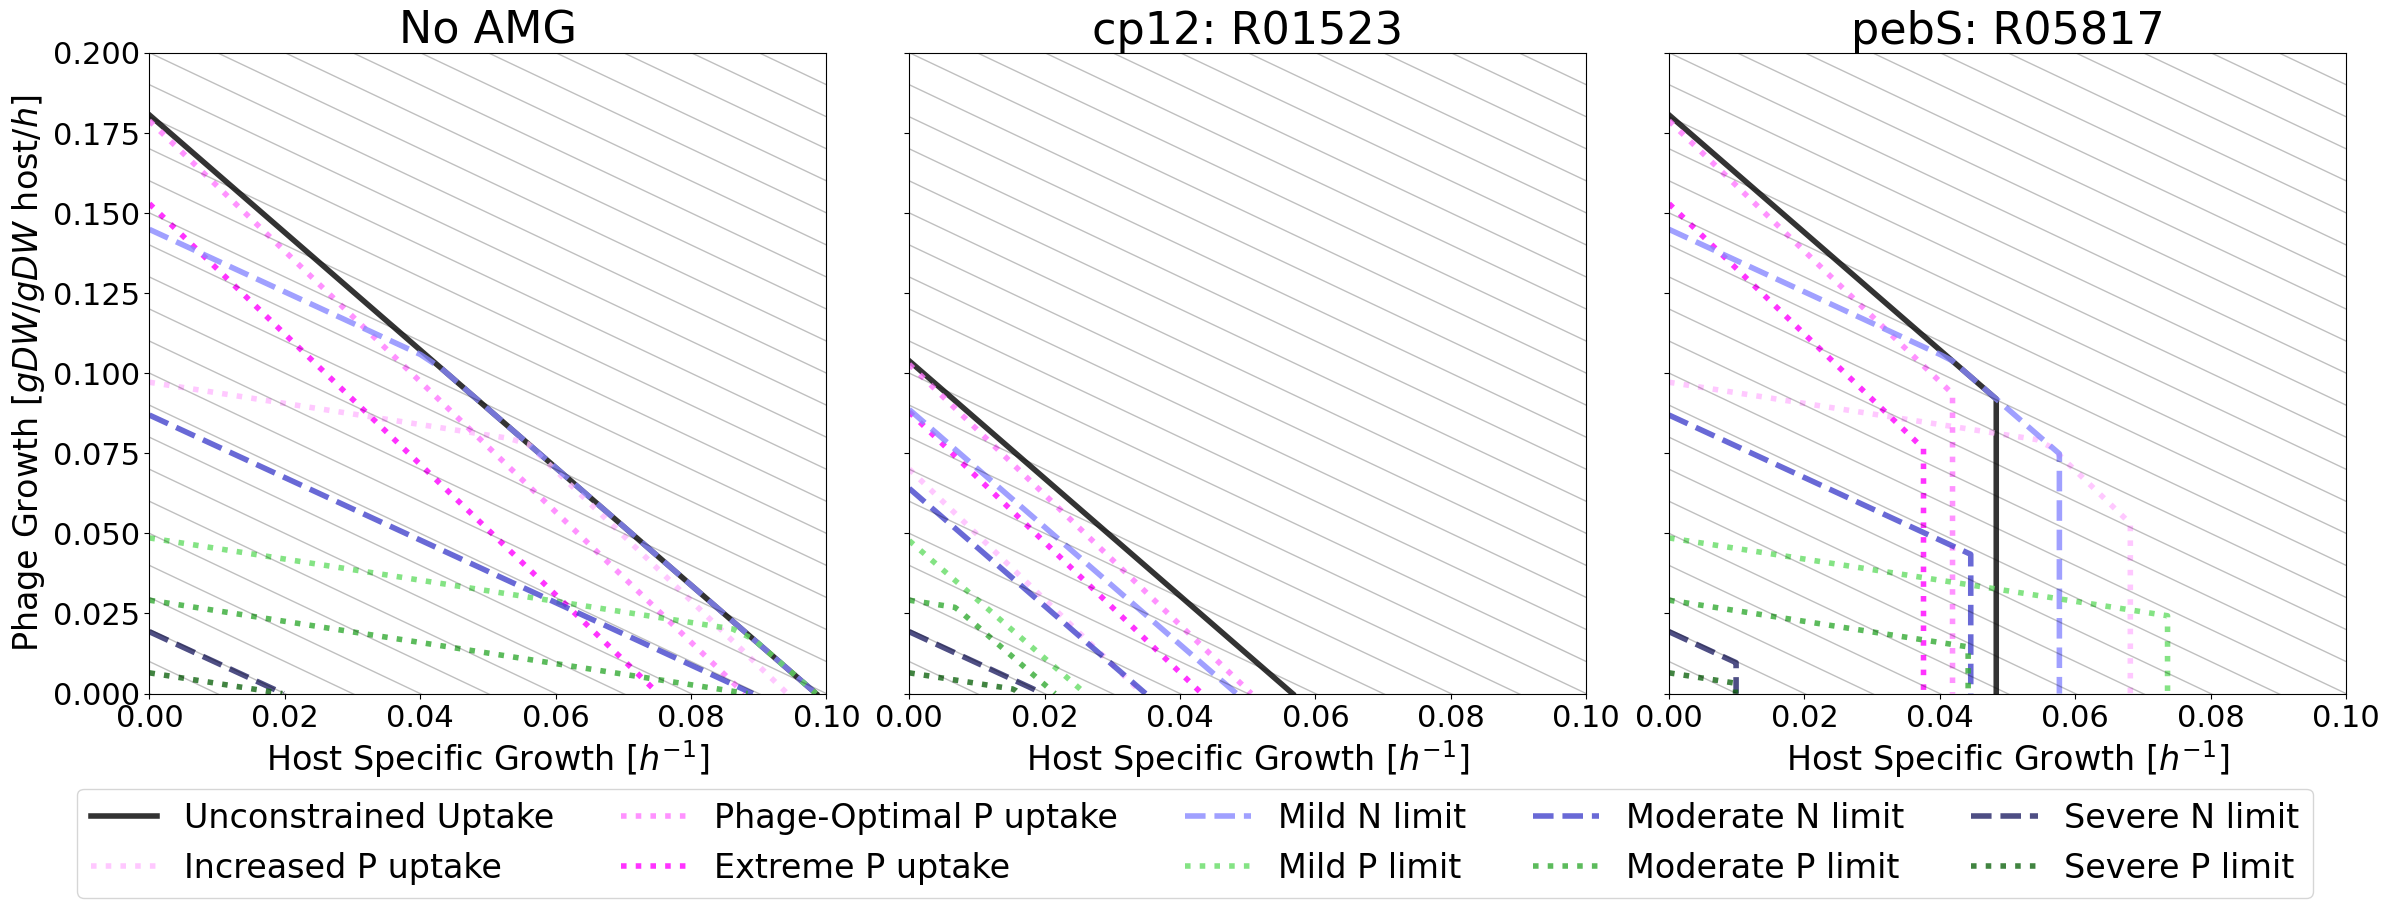

In [12]:
amgs_example = {
    "No AMG": "",
    "R01523": "absolute decrease",
    "R05817": "raw increase",
}
fig, axs = plt.subplots(1, 3, figsize=(24, 8), sharey=True)
for (amg, direction), ax in zip(amgs_example.items(), axs.flatten()):
    print("\n", amg, direction, "\n", "-" * 10)
    scenario_outputs = {}
    for scenario in scenarios:
        print(scenario)
        host_biomass_frac = []
        phage_biomass_max_frac = []
        phage_biomass_min_frac = []
        for frac in host_optimum_frac:
            # for frac in np.linspace(0, 1, 5):
            with model as host_model:
                set_nutrient_limits(host_model, scenario)
                host_model.objective = (
                    host_model.reactions.PHM2_prodrxn_VN.flux_expression
                )
                if amg != "No AMG":
                    set_amg_limits(host_model, amg, direction, optimum_fraction=0.5)
                host_model.objective = host_model.reactions.BIOMASS.flux_expression
                host_optimum = host_model.slim_optimize()
                host_bio = host_optimum * frac
                host_biomass_frac.append(host_bio)

                host_model.reactions.BIOMASS.bounds = host_bio, host_bio

                # Now, with AMG and biomass fixed, compute the optimal phage
                # biomass
                host_model.objective = (
                    host_model.reactions.PHM2_prodrxn_VN.flux_expression
                )
                phage_biomass_max_frac.append(host_model.slim_optimize())
                host_model.objective = (
                    -host_model.reactions.PHM2_prodrxn_VN.flux_expression
                )
                phage_biomass_min_frac.append(host_model.slim_optimize())
        host_biomass_frac.append(host_biomass_frac[-1])
        phage_biomass_min_frac.append(phage_biomass_min_frac[-1])
        phage_biomass_max_frac.append(phage_biomass_min_frac[-1])
        med4_opt = pd.DataFrame(
            np.array(
                [host_biomass_frac, phage_biomass_max_frac, phage_biomass_min_frac]
            ).T,
            columns=["host biomass", "phage biomass max", "phage biomass min"],
            dtype="float",
        )
        scenario_outputs[scenario] = med4_opt.map(
            lambda x: x if np.abs(x) > 1e-10 else 0
        )

    for scenario in scenarios:
        scenario_outputs[scenario].plot(
            x="host biomass",
            y="phage biomass max",
            ax=ax,
            label=scenario,
            color=scenario_colors[scenario],
            linewidth=4,
            alpha=0.8,
            linestyle="dashed"
            if "N" in scenario
            else "dotted"
            if "P" in scenario
            else "solid",
        )
    for m in np.linspace(0.0, 0.4, 41):
        ax.plot(host_optimum_frac, m - host_optimum_frac, "k-", linewidth=1, alpha=0.25)
    ax.set_xlim(0, 0.1)
    ax.set_ylim(0, 0.2)
    ax.set_xlabel(r"Host Specific Growth $[h^{-1}]$", fontsize=24)
    ax.set_ylabel(r"Phage Growth $[gDW /gDW$ host$ / h]$", fontsize=24)
    ax.tick_params(labelsize=22)
    ax.legend().remove()
    if direction:
        ax.set_title(f"{amg_rxn_names[amg]}", fontsize=32)
    else:
        ax.set_title(amg, fontsize=32)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(
    by_label, fontsize=24, ncols=5, loc="lower center", bbox_to_anchor=(0.5, -0.15)
)
fig.tight_layout()
plt.show()